In [5]:
!pip install nltk

  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434676 sha256=d15c3b92fd232be5bbc216aa01a55095e6a8a9026920b882eb571baa247e77c0
  Stored in directory: c:\users\administrator\appdata\local\pip\cache\wheels\45\6c\46\a1865e7ba706b3817f5d1b2ff7ce8996aabdd0d03d47ba0266
Successfully built nltk


In [76]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
from tqdm import tqdm
import re
import gc
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.utils import to_categorical
import random
# from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

import functools
top1_acc = functools.partial(tf.keras.metrics.top_k_categorical_accuracy, k=1)
top1_acc.__name__ = 'top1_acc'

#set random seed for the session and also for tensorflow that runs in background for keras
# set_random_seed(123)
# random.seed(123)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

2.1.0


In [66]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape
test.shape
train.head()
test.head()


(146811, 3)

(60427, 2)

,review_id,review,rating
0,0,Ga disappointed neat products .. Meletot Hilsn...,1
1,1,"Rdtanya replace broken glass, broken chargernya",1
2,2,Nyesel bngt dsni shopping antecedent photo mes...,1
3,3,Sent a light blue suit goods ga want a refund,1
4,4,Pendants came with dents and scratches on its ...,1


,review_id,review
0,1,"Great danger, cool, motif and cantik2 jg model..."
1,2,One of the shades don't fit well
2,3,Very comfortable
3,4,Fast delivery. Product expiry is on Dec 2022. ...
4,5,it's sooooo cute! i like playing with the glit...


In [79]:
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['review']):
        
        #remove non-alphabetic characters
#         review_text = re.sub("[^a-zA-Z0-9]"," ", sent)
        review_text = sent
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)


train_sentence = clean_sentences(train)
test_sentence = clean_sentences(test)
print(len(train_sentence))
print(len(test_sentence))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60427/60427 [00:13<00:00, 4338.82it/s]

146811
60427


In [80]:
y_target = to_categorical(train.rating.values)
n_classes = y_target.shape[1]

train_x, val_x, train_y, val_y = train_test_split(train_sentence, y_target, test_size=0.2, stratify=y_target)


In [81]:
unique_words = set()
len_max = 0

for sent in tqdm(train_x):
    
    unique_words.update(sent)
    
    if(len_max < len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117448/117448 [00:00<00:00, 476110.16it/s]

65246
354


In [82]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(train_x))

#texts_to_sequences(texts)

    # Arguments- texts: list of texts to turn to sequences.
    # Return: list of sequences (one per text input).
train_x = tokenizer.texts_to_sequences(train_x)
val_x = tokenizer.texts_to_sequences(val_x)
test_x = tokenizer.texts_to_sequences(test_sentence)

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.

train_x = sequence.pad_sequences(train_x, maxlen=len_max)
val_x = sequence.pad_sequences(val_x, maxlen=len_max)
test_x = sequence.pad_sequences(test_x, maxlen=len_max)

print(train_x.shape, val_x.shape, test_x.shape)


(117448, 354) (29363, 354) (60427, 354)


In [83]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor= 'val_accuracy', patience = 2)
callback = [early_stopping]

model = Sequential()
model.add(Embedding(len(list(unique_words)), 300, input_length=len_max))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=False))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy', top1_acc])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 354, 300)          19573800  
_________________________________________________________________
lstm_6 (LSTM)                (None, 354, 128)          219648    
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 606       
Total params: 19,849,962
Trainable params: 19,849,962
Non-trainable params: 0
__________________________________________

In [84]:
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=6, batch_size=256, verbose=1, callbacks=callback)


Train on 117448 samples, validate on 29363 samples
Epoch 1/6
117448/117448 [==============================] - 1234s 11ms/sample - loss: 1.1614 - accuracy: 0.4497 - top1_acc: 0.4497 - val_loss: 1.0473 - val_accuracy: 0.4856 - val_top1_acc: 0.4856
Epoch 2/6
117448/117448 [==============================] - 1328s 11ms/sample - loss: 0.9919 - accuracy: 0.5142 - top1_acc: 0.5142 - val_loss: 1.0540 - val_accuracy: 0.4921 - val_top1_acc: 0.4921
Epoch 3/6
117448/117448 [==============================] - 1328s 11ms/sample - loss: 0.8928 - accuracy: 0.5541 - top1_acc: 0.5541 - val_loss: 1.1148 - val_accuracy: 0.4842 - val_top1_acc: 0.4842
Epoch 4/6
117448/117448 [==============================] - 1347s 11ms/sample - loss: 0.8184 - accuracy: 0.5786 - top1_acc: 0.5786 - val_loss: 1.2034 - val_accuracy: 0.4800 - val_top1_acc: 0.4800


Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

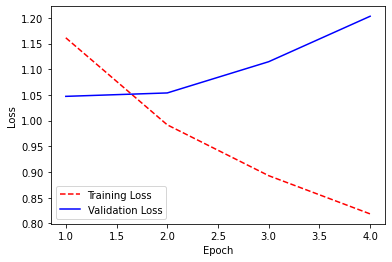

In [85]:
# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [86]:
y_pred = model.predict_classes(test_x)

sub_file = pd.read_csv('sampleSubmission.csv')
sub_file = pd.DataFrame({
    'review_id': test.review_id,
    'rating': y_pred
})
sub_file.shape
sub_file.head()
sub_file.to_csv('submission_keep_emojis.csv', index=False)

sub_file.groupby(['rating']).size()


(60427, 2)

,review_id,rating
0,1,4
1,2,1
2,3,5
3,4,4
4,5,4


rating
1     5292
2     2812
3    15018
4    33754
5     3551
dtype: int64

In [34]:
del cleaned_test, cleaned_train
gc.collect();
